# How to set the threshold using the Receiver operating characteristic (ROC) Curve


What is it?
* A graphic scheme for binary classification. 

What it represent?
* On the x-axis you have the False Positive Rate (FPR) 
* On the y-axis the True Positive Rate (TPR) 
* Each point of the curve is associated to a possible threshold 

How do I choose the threshold?
* You can choose the threshold you prefer as a trade-off between the TPR and  the FPR. However, **we will focus on FPR$<0.1$**

How can I generate the ROC?
* **To generate the ROC curve you need two arrays**: score and label

* These two arrays contains informations on the classifier positive and negative decision, respectively: H1 (similarity estimated between the same watermark) and H0 (similarity estimated between two different watermark).

* **In the score array**,  goes the similarity values between the watemark extracted from the watermarked image and those extracted from the attacked one.

* **In the label array**,  goes values equals either to 1 or 0. We put 1 if the watermarks extracted from the watermarked image and the attacked image, to estimate the corresponding similarity, are the same (H1 hypothesis). Otherwise, we put 0 (H0 hyphotesis).

AN EXAMPLE:


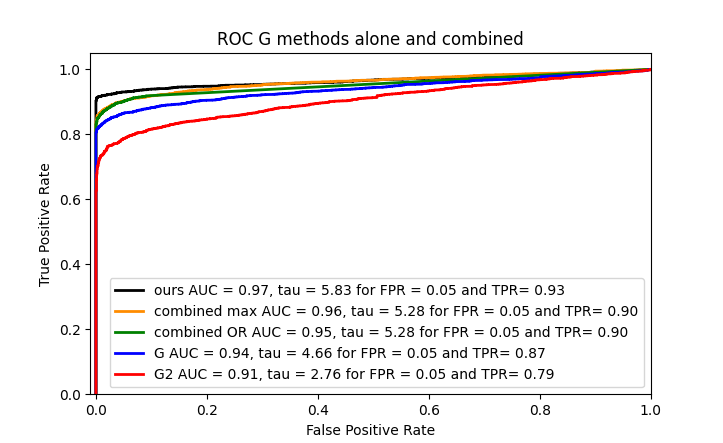




## A Toy-Example (Example 1)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 5]

from sklearn.metrics import roc_curve, auc

score = np.asarray([1, 0.9, 0.8, 0.7, 0.75, 0.76, 0.88, 0.91, 0.7, 0.55, 0.6,
                      0.2, 0.5, 0.6, 0.7, 0.3, 0.44, 0.55, 0.61, 0.21, 0.5, 0.1])
label = np.asarray([1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0])
#compute ROC
fpr, tpr, tau = roc_curve(label, score, drop_intermediate=False)
#compute AUC
roc_auc = auc(fpr, tpr)

### How to plot the ROC

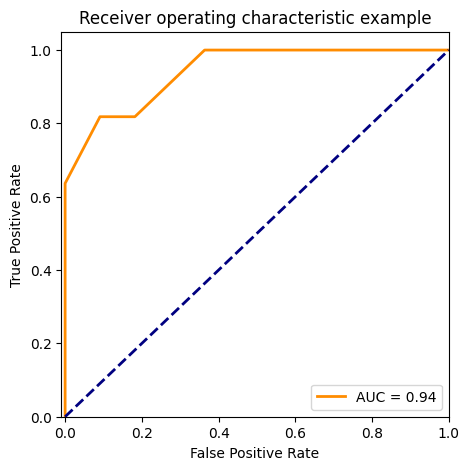

In [9]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# How do I set the threshold?
A good threshold has a good trade off between TPR and FPR. Generally, the condition you care about is that your FPR never exceed a value of 0.05. For this challenge, all FPR $\leq 0.1$ are allowed. 

In [10]:
idx_fpr = np.where((fpr-0.05)==min(i for i in (fpr-0.05) if i > 0)) #locate the position corresponding to FPR=0.05
print('For a FPR approximately equals to 0.05 corresponds a TPR equals to %0.2f' % tpr[idx_fpr[0][0]])
print('For a FPR approximately equals to 0.05 corresponds a threshold equals to %0.2f' % tau[idx_fpr[0][0]])
print('Check FPR %0.2f' % fpr[idx_fpr[0][0]]) #"errors" due to approximations are possible when you do not have many data

For a FPR approximately equals to 0.05 corresponds a TPR equals to 0.82
For a FPR approximately equals to 0.05 corresponds a threshold equals to 0.70
Check FPR 0.09


### What FPR should I choose?

(Take Note)

# ROC applied to Watermarking (Example 2)

Let's apply what we learned to watermarking.

Function to embed/detect spread spectrum and apply a random attack.

In [17]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.fft import dct, idct


import random

# def embedding(image, mark_size, alpha, v='multiplicative'):
#     # Get the DCT transform of the image
#     ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')

#     # Get the locations of the most perceptually significant components
#     sign = np.sign(ori_dct)
#     ori_dct = abs(ori_dct)
#     locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
#     rows = image.shape[0]
#     locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

#     # Generate a watermark
#     mark = np.random.uniform(0.0, 1.0, mark_size)
#     mark = np.uint8(np.rint(mark))
#     np.save('mark.npy', mark)

#     # Embed the watermark
#     watermarked_dct = ori_dct.copy()
#     for idx, (loc,mark_val) in enumerate(zip(locations[1:], mark)):
#         if v == 'additive':
#             watermarked_dct[loc] += (alpha * mark_val)
#         elif v == 'multiplicative':
#             watermarked_dct[loc] *= 1 + ( alpha * mark_val)

#     # Restore sign and o back to spatial domain
#     watermarked_dct *= sign
#     watermarked = np.uint8(idct(idct(watermarked_dct,axis=1, norm='ortho'),axis=0, norm='ortho'))

#     return mark, watermarked

ALPHA: float = 0.1

def embedding(input1: str, input2: str) -> np.ndarray:
    """Embed a binary watermark into a grayscale image using DCT.

    Args:
        input1: Path to the original image on disk.  The image must be
            grayscale (one channel) and of size 512×512.
        input2: Path to the watermark file (``.npy``) on disk containing
            exactly 1024 bits (0 or 1).

    Returns:
        The watermarked image as a NumPy array of dtype ``uint8``.  The
        caller may write this image to disk if needed.
    """
    # Read the original image and ensure it exists.
    host = cv2.imread(input1, cv2.IMREAD_GRAYSCALE)
    if host is None:
        raise FileNotFoundError(f"Could not read input image: {input1}")
    if host.shape[0] != 512 or host.shape[1] != 512:
        raise ValueError("Input image must be 512×512 pixels")

    # Load the watermark bits.  Flatten to 1D and verify length.
    watermark = np.load(input2).astype(np.uint8).flatten()
    if watermark.ndim != 1 or watermark.size != 1024:
        raise ValueError("Watermark must be a one‑dimensional array of length 1024")

    # Map bits from {0,1} to {-1,1}.  Bit 0 becomes ‑1, bit 1 becomes +1.
    wm_mapped = 2 * watermark.astype(np.float32) - 1.0

    # Convert the host image to float32 for DCT.
    host_f = host.astype(np.float32)
    # Compute the 2D Discrete Cosine Transform (DCT).
    dct_host = cv2.dct(host_f)

    # Flatten and sort coefficients by magnitude (descending).  Skip the
    # first element (DC term) which is typically the largest.
    flat = dct_host.ravel()
    # Indices sorted by absolute value descending
    sorted_indices = np.argsort(np.abs(flat))[::-1]
    # Exclude the DC component at index 0 and take the next 1024 indices
    embed_indices = sorted_indices[1:1025]

    # Embed the watermark multiplicatively.
    for i, idx in enumerate(embed_indices):
        r, c = divmod(int(idx), dct_host.shape[1])
        coeff = dct_host[r, c]
        # Apply multiplicative modulation: c' = c * (1 + alpha * w)
        dct_host[r, c] = coeff * (1.0 + ALPHA * wm_mapped[i])

    # Compute the inverse DCT to obtain the watermarked image.
    watermarked_f = cv2.idct(dct_host)
    # Round and clip values to valid intensity range.
    watermarked = np.clip(np.round(watermarked_f), 0, 255).astype(np.uint8)

    return watermarked

# def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
#     ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
#     wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')

#     # Get the locations of the most perceptually significant components
#     ori_dct = abs(ori_dct)
#     wat_dct = abs(wat_dct)
#     locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
#     rows = image.shape[0]
#     locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

#     # Generate a watermark
#     w_ex = np.zeros(mark_size, dtype=np.float64)

#     # Embed the watermark
#     for idx, loc in enumerate(locations[1:mark_size+1]):
#         if v=='additive':
#             w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) /alpha
#         elif v=='multiplicative':
#             w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) / (alpha*ori_dct[loc])
            
#     return w_ex

TAU: float = 0.99

def detection(original: str, watermarked: str, attacked: str) :
    """Detect a spread‑spectrum watermark and compute the WPSNR.

    Args:
        input1: Path to the original (unwatermarked) image.
        input2: Path to the watermarked image.
        input3: Path to the attacked image.

    Returns:
        A tuple ``(output1, output2)`` where ``output1`` is ``1`` if
        the watermark is deemed present (similarity ≥ ``TAU``) and
        ``0`` otherwise, and ``output2`` is the WPSNR between the
        watermarked and attacked images in decibels.
    """
    # Load the three images in grayscale
    f_original = original.astype(np.float32)
    f_watermarked = watermarked.astype(np.float32)
    f_attacked = attacked.astype(np.float32)
    # Compute 2D DCTs
    dct_orig = cv2.dct(f_original)
    dct_wm = cv2.dct(f_watermarked)
    dct_att = cv2.dct(f_attacked)
    # Sort DCT coefficients of the original image by magnitude
    flat = dct_orig.ravel()
    sorted_idx = np.argsort(np.abs(flat))[::-1]
    # Exclude DC term and select the next 1024 coefficients
    embed_indices = sorted_idx[1:1025]
    # Derive sign bits from differences between watermarked/original and attacked/original
    ref_bits = np.zeros(1024, dtype=np.uint8)
    att_bits = np.zeros(1024, dtype=np.uint8)
    for i, idx in enumerate(embed_indices):
        r, c = divmod(int(idx), dct_orig.shape[1])
        # If the watermarked coefficient increased relative to the original then bit=1, else 0
        ref_bits[i] = 1 if (dct_wm[r, c] - dct_orig[r, c]) >= 0 else 0
        att_bits[i] = 1 if (dct_att[r, c] - dct_orig[r, c]) >= 0 else 0
    # Compute similarity as fraction of matching bits
    similarity = float(np.sum(ref_bits == att_bits)) / len(ref_bits)
    # Compute WPSNR between the watermarked and attacked images
    output1 = 1 if similarity >= TAU else 0
    return ref_bits, att_bits

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / np.sqrt(np.sum(np.multiply(X_star, X_star)))
    return s

#this seed was set just to make you obtain the same result
random.seed(3)
def awgn(img, std, seed):
  mean = 0.0   # some constant
  #np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return attacked

def blur(img, sigma):
  from scipy.ndimage.filters import gaussian_filter
  attacked = gaussian_filter(img, sigma)
  return attacked

def sharpening(img, sigma, alpha):
  import scipy
  from scipy.ndimage import gaussian_filter
  import matplotlib.pyplot as plt

  #print(img/255)
  filter_blurred_f = gaussian_filter(img, sigma)

  attacked = img + alpha * (img - filter_blurred_f)
  return attacked

def median(img, kernel_size):
  from scipy.signal import medfilt
  attacked = medfilt(img, kernel_size)
  return attacked

def resizing(img, scale):
  from skimage.transform import rescale
  x, y = img.shape
  attacked = rescale(img, scale)
  attacked = rescale(attacked, 1/scale)
  attacked = attacked[:x, :y]
  return attacked

def jpeg_compression(img, QF):
  from PIL import Image
  img = Image.fromarray(img)
  img.save('tmp.jpg',"JPEG", quality=QF)
  attacked = Image.open('tmp.jpg')
  attacked = np.asarray(attacked,dtype=np.uint8)
  os.remove('tmp.jpg')

  return attacked

def random_attack(img):
  i = random.randint(1,7)
  if i==1:
    attacked = awgn(img, 3., 123)
  elif i==2:
    attacked = blur(img, [3, 3])
  elif i==3:
    attacked = sharpening(img, 1, 1)
  elif i==4:
    attacked = median(img, [3, 3])
  elif i==5:
    attacked = resizing(img, 0.8)
  elif i==6:
    attacked = jpeg_compression(img, 75)
  elif i ==7:
     attacked = img
  return attacked

In [8]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import random

# Read image
im = cv2.imread('../images/0001.bmp', 0)
print('Image shape: ', im.shape)

Image shape:  (512, 512)


Build a mini dataset of 999 samples for the ROC.

**NOTE**: In this example we use Spread Spectrum.

In [19]:
#some parameters for the spread spectrum
mark_size = 1024
alpha = 0.1
v = 'multiplicative'
np.random.seed(seed=124)


#scores and labels are two lists we will use to append the values of similarity and their labels
#In scores we will append the similarity between our watermarked image and the attacked one,
# or  between the attacked watermark and a random watermark
#In labels we will append the 1 if the scores was computed between the watermarked image and the attacked one,
#and 0 otherwise
scores = []
labels = []
#Embed Watermark
mark = np.load('acme.npy')
watermarked = embedding("../images/0001.bmp", "acme.npy")


sample = 0
while sample<500:
  #fakemark is the watermark for H0
  fakemark = np.random.uniform(0.0, 1.0, mark_size)
  fakemark = np.uint8(np.rint(fakemark))
  #random attack to watermarked image
  res_att = random_attack(watermarked)
  #extract attacked watermark
  #wat_attacked = detection(im, res_att, alpha, mark_size, v)
  #wat_extracted = detection(im, watermarked, alpha, mark_size, v)
  #wat_attacked = detection(im, res_att, watermarked)
  #wat_extracted = detection(im, watermarked, watermarked)
  wat_extracted, wat_attacked = detection(im, res_att, watermarked)
  #compute similarity H1
  scores.append(similarity(wat_extracted, wat_attacked))
  labels.append(1)
  #compute similarity H0
  scores.append(similarity(fakemark, wat_attacked))
  labels.append(0)
  sample += 1

print('scores array: ', scores)
print('labels array: ', labels)

C:\Users\tamas\AppData\Local\Temp\ipykernel_50796\4229836655.py:179: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


scores array:  [np.float64(14.524084122857563), np.float64(11.51299351202124), np.float64(22.583179581272432), np.float64(11.33587053491322), np.float64(12.752854351777373), np.float64(11.42443202346723), np.float64(12.752854351777373), np.float64(11.158747557805201), np.float64(10.715940115035153), np.float64(11.158747557805201), np.float64(22.583179581272432), np.float64(11.468712767744234), np.float64(22.583179581272432), np.float64(11.42443202346723), np.float64(12.752854351777373), np.float64(11.468712767744234), np.float64(22.583179581272432), np.float64(11.114466813528196), np.float64(21.210476508685282), np.float64(10.760220859312158), np.float64(22.583179581272432), np.float64(11.867239466237278), np.float64(22.583179581272432), np.float64(11.247309046359211), np.float64(22.583179581272432), np.float64(10.361694160819116), np.float64(22.583179581272432), np.float64(11.247309046359211), np.float64(22.583179581272432), np.float64(11.645835744852254), np.float64(22.58317958127243

## Compute the ROC

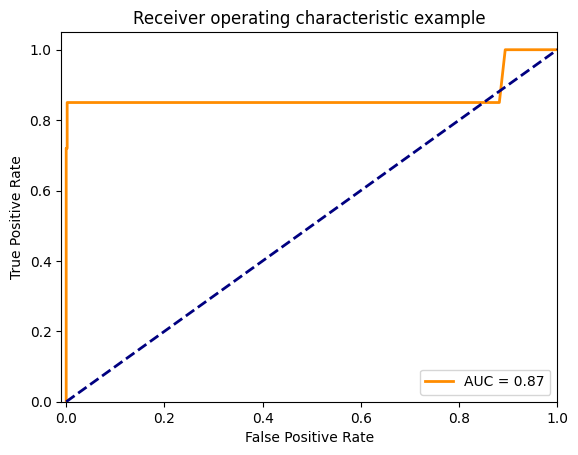

For a FPR approximately equals to 0.05 corresponds a TPR equals to 0.85
For a FPR approximately equals to 0.05 corresponds a threshold equals to 12.13
Check FPR 0.06


In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

#compute ROC
fpr, tpr, tau = roc_curve(np.asarray(labels), np.asarray(scores), drop_intermediate=False)
#compute AUC
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
idx_tpr = np.where((fpr-0.05)==min(i for i in (fpr-0.05) if i > 0))
print('For a FPR approximately equals to 0.05 corresponds a TPR equals to %0.2f' % tpr[idx_tpr[0][0]])
print('For a FPR approximately equals to 0.05 corresponds a threshold equals to %0.2f' % tau[idx_tpr[0][0]])
print('Check FPR %0.2f' % fpr[idx_tpr[0][0]])